# Xgboost

In [10]:
# !pip install xgboost

In [40]:

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, ParameterGrid
from sklearn.metrics import (
    recall_score, precision_score, f1_score,
    accuracy_score, roc_auc_score, classification_report
)
from imblearn.over_sampling import SMOTE

In [2]:
def load_data():
    df = pd.read_csv('../data/ywan1077/citizens_data/BrownDSI_masked_capstone_data.csv_20250401031515')
    # df = pd.read_csv('/users/ywan1077/data/yye45/citizens_data/BrownDSI_masked_capstone_data.csv_20250401031515')
    return df

In [3]:
df = load_data()
df.head()

,masked_dep_acct_num,masked_bank_num,masked_account_type,masked_id,masked_product_code,bucket_days_since_open,number_of_owners,total_deposit_amount,item_amt,deposit_dt,...,drawee_sum,drawee_cnt,drawee_avg,drawee_max,drawee_min,RDI_DT,RETURN_REASON,return_target,over_draft_amount,month_num
0,0,0,0,0,0,5000+,1,517.81,517.81,2024-08-01,...,1882.21,4.0,470.5525,535.92,400.77,NaN,NaN,0,0,8
1,2,0,0,2,1,0-1000,1,150.00,150.00,2024-04-25,...,150.00,1.0,150.0000,150.00,150.00,NaN,NaN,0,0,4
2,3,0,0,3,0,5000+,0,2603.24,2451.00,2024-03-18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,3
3,4,0,0,4,1,5000+,0,770.00,770.00,2024-11-29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,11
4,7,0,0,7,1,2000-5000,2,10776.63,145.00,2024-05-29,...,7860.00,1.0,7860.0000,7860.00,7860.00,NaN,NaN,0,0,5


In [4]:
def xgboost_pipeline(df):
    """
    XGBoost Feature Engineering Pipeline

    This pipeline performs minimal cleaning and targeted feature engineering
    to prepare the dataset for XGBoost modeling. Specifically, it:

    - Drops irrelevant or identifier columns that are not useful for prediction
    - Extracts temporal features (quarter, week) from the deposit date
    - Creates ratio-based and volatility-based transaction features
    - Creates frequency-based features from historical transaction dates
    - Creates behavioral flags based on deposit amount anomalies
    - Processes bucketed and binary categorical features into numeric form
    - Preserves missing values (np.nan) without imputation
    - Does not perform feature scaling or one-hot encoding
    - Leaves outlier values as-is without clipping

    The resulting dataset is fully numeric, with missing values retained, and ready for XGBoost models.
    """

    cols_to_drop = [
        'masked_dep_acct_num',
        'masked_id',
        'channel',
        'RDI_DT',
        'RETURN_REASON',
        'over_draft_amount',
        'return_target'  
    ]

    df = df.drop(columns=cols_to_drop, errors='ignore')

    # --------------- process deposit_dt columns --------------- 
    df['deposit_dt'] = pd.to_datetime(df['deposit_dt'], errors='coerce')
    df['fe_deposit_quarter'] = df['deposit_dt'].dt.quarter
    df['fe_deposit_week'] = df['deposit_dt'].dt.isocalendar().week
    df = df.drop(columns=['deposit_dt'])


    # --------------- process item_amt, total_deposit_amount, relationship_balance columns --------------- 
    ## Ratio of current deposit item amount to total deposit amount, large single deposits are potentially unusual 如果一笔交易占今天总交易很大一部分会不会是诈骗
    epsilon = 1e-6
    denom_balance = df['relationship_balance']
    denom_balance = np.where(denom_balance <= 0, epsilon, denom_balance)

    df['fe_amt_ratio_to_total'] = df['item_amt'] / (df['total_deposit_amount'] + 1)
    ## Ratio of current deposit item amount to prior day's total balance, Some frauds are small balance with large deposits all of a sudden. 如果一笔交易占用户总余额很大一部分会不会是诈骗
    df['fe_amt_ratio_to_balance'] = (df['item_amt'] / denom_balance).clip(upper=1e6)
    ## Ratio of total deposit amount to prior day's total balance, Some frauds are small balance with large deposits all of a sudden. 如果今天的总交易占用户总余额很大一部分会不会是诈骗
    df['fe_total_amt_ratio_to_balance'] = (df['total_deposit_amount'] / denom_balance).clip(upper=1e6)
    ## Difference between current deposit amount and previous transaction amount, abnormal fluctuations 如果这笔交易比上一笔变化很多会不会是诈骗
    df['fe_amt_change_from_prev'] = df['item_amt'] - df['prevtran1']
    ## Flag indicating whether the current deposit item is 1.5x larger than the past 30-day maximum deposit, Is it significantly higher than the largest deposit in the last 30 days 如果一笔交易是这一个月的最大交易会不会是诈骗
    df['fe_high_amt_flag'] = (df['item_amt'] > (df['max_deposit_amount30d'] * 1.5)).astype(int)
    ## Ratio of maximum single deposit amount in past 30 days to the total deposit amount 
    df['fe_max30d_ratio_total'] = df['max_deposit_amount30d'] / (df['total_deposit_amount'] + 1)

    # --------------- process rdis columns --------------- 
    ## fill NA as 0 to rdis
    df['rdis'] = df['rdis'].fillna(0)
    df['fe_rdis_flag'] = (df['rdis'] > 0).astype(int)

    # --------------- process prevtrandate columns --------------- 
    ## process prevtrandate to capture short-term transaction frequency.
    prevtrandate_cols = [f'prevtrandate{i}' for i in range(1, 11)]
    prevtran_cols = [f'prevtran{i}' for i in range(1, 11)]
    # Create transaction count features
    ## Number of transactions within 1 day
    df['fe_num_trans_in_1d'] = (df[prevtrandate_cols] <= 1).sum(axis=1)
    ## Number of transactions within 5 days
    df['fe_num_trans_in_5d'] = (df[prevtrandate_cols] <= 5).sum(axis=1)
    ## Number of transactions within 10 days
    df['fe_num_trans_in_10d'] = (df[prevtrandate_cols] <= 10).sum(axis=1)
    ## Average days between previous transactions
    df['fe_avg_prevtrandate'] = df[prevtrandate_cols].mean(axis=1)
    ## Standard deviation of days between previous transactions
    df['fe_std_prevtrandate'] = df[prevtrandate_cols].std(axis=1)
    ## Rolling mean of the most recent 3 and 5 previous transaction days
    df['fe_rolling_mean_prevtrandate_3'] = df[prevtrandate_cols[:3]].mean(axis=1)
    df['fe_rolling_mean_prevtrandate_5'] = df[prevtrandate_cols[:5]].mean(axis=1)
    ## Rolling standard deviation of the most recent 3 and 5 previous transaction days
    df['fe_rolling_std_prevtrandate_3'] = df[prevtrandate_cols[:3]].std(axis=1)
    df['fe_rolling_std_prevtrandate_5'] = df[prevtrandate_cols[:5]].std(axis=1)


    # ------------ process prevtran columns ------------
    # volatility of item_amt compared to historical transaction amounts
    ## Mean of previous 10 deposits  ps If there is all NaN, the result of std is NaN!
    df['fe_avg_prevtran_amt'] = df[prevtran_cols].mean(axis=1)
    ## Standard deviation of previous 10 deposits ps If there is only 1 valid number or all NaN, the result of std is NaN!
    df['fe_std_prevtran_amt'] = df[prevtran_cols].std(axis=1)
    ## Maximum amount among previous 10 deposits ps If there is all NaN, the result of std is NaN!
    df['fe_max_prevtran_amt'] = df[prevtran_cols].max(axis=1)
    ## Current deposit amount compared to historical average 
    df['fe_amt_current_vs_avg'] = df['item_amt'] / (df['fe_avg_prevtran_amt'] + 1)
    ## Current deposit amount compared to historical maximum 
    df['fe_amt_current_vs_max'] = df['item_amt'] / (df['fe_max_prevtran_amt'] + 1)
    # Rolling part to capture short-term behavioral trends from the latest 3 or 5 transactions.
    # Rolling mean of the most recent 3 and 5 previous transactions ps If there is all NaN, the result of std is NaN!
    df['fe_rolling_mean_prevtran_3'] = df[prevtran_cols[:3]].mean(axis=1)
    df['fe_rolling_mean_prevtran_5'] = df[prevtran_cols[:5]].mean(axis=1)
    # Rolling standard deviation of the most recent 3 and 5 previous transactions ps if If there is only 1 valid number or all NaN, the result is NaN!
    df['fe_rolling_std_prevtran_3'] = df[prevtran_cols[:3]].std(axis=1)
    df['fe_rolling_std_prevtran_5'] = df[prevtran_cols[:5]].std(axis=1)
    ## Create a feature indicating whether the current deposit is the first known deposit
    df['fe_is_first_deposit'] = df[prevtran_cols].isna().all(axis=1).astype(int)


    # --------------- Label Encoding ---------------
    ##  --------------- process mapping_bucket_days columns to approximate days(med) --------------- 
    mapping_bucket_days = {
        '0-1000': 500,
        '1000-2000': 1500,
        '2000-5000': 3500,
        '5000+': 6000
    }
    df['fe_days_since_open'] = df['bucket_days_since_open'].map(mapping_bucket_days)
    df = df.drop(columns=['bucket_days_since_open'])
    ## --------------- process oao_flg columns ---------------
    mapping_oao_flg = {
        'N': 0,
        'Y': 1
    }
    df['fe_oao_flg'] = df['oao_flg'].map(mapping_oao_flg)
    df = df.drop(columns=['oao_flg'])
    ## --------------- process onus_ind columns ---------------
    mapping_onus_ind = {
        'F': 0,
        'T': 1
    }
    df['fe_onus_ind'] = df['onus_ind'].map(mapping_onus_ind)
    df = df.drop(columns=['onus_ind'])
    ## --------------- process treasury_check_ind columns ---------------
    mapping_treasury_check_ind = {
        'N': 0,
        'Y': 1
    }
    df['fe_treasury_check_ind'] = df['treasury_check_ind'].map(mapping_treasury_check_ind)
    df = df.drop(columns=['treasury_check_ind'])
    ## --------------- process heloc_ind columns ---------------
    mapping_heloc_ind = {
        'N': 0,
        'Y': 1
    }
    df['fe_heloc_ind'] = df['heloc_ind'].map(mapping_heloc_ind)
    df = df.drop(columns=['heloc_ind'])

    
    df_xgboost = df.copy()

    return df_xgboost


In [ ]:
df_processed = xgboost_pipeline(df)

X = df_processed
y = df['return_target']  

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)



In [6]:
X_train.shape

(14212, 69)

In [ ]:
pos = sum(y_train == 1)
neg = sum(y_train == 0)
print("scale_pos_weight：", round(neg / pos, 2))

scale_pos_weight 应设为： 1.99


## training

In [ ]:
def recall_eval_xgb(y_pred, dtrain):
    y_true = dtrain.get_label()
    y_pred_bin = (y_pred > 0.5).astype(int)
    recall = recall_score(y_true, y_pred_bin)
    return 'recall', recall

def tune_xgb_native(X_train, y_train, X_test, y_test, thresholds=[0.5, 0.6, 0.7], verbose=True):
    # Split validation set
    X_fit, X_val, y_fit, y_val = train_test_split(
        X_train, y_train,
        test_size=0.2,
        stratify=y_train,
        random_state=42
    )

    # ================== Stage 1: Coarse tuning ==================
    param_grid_stage1 = {
    "learning_rate":      [0.01, 0.015],         # 0.01
    "max_depth":          [3, 5, 7],                   
    "min_child_weight":   [1],                       # 1
    "subsample":          [0.55],             # 0.55
    "colsample_bytree":   [0.55],             # 0.55
    "gamma":              [0.1, 0.2, 0.5],                      
    "lambda":             [1, 3, 5],               
    "alpha":              [1, 15, 30],        
    "scale_pos_weight":   [2.5, 3.5]               # 3.5
    }


    pg1 = list(ParameterGrid(param_grid_stage1))
    scores1 = []

    for params in pg1:
        fold_scores = []
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        for train_idx, val_idx in cv.split(X_fit, y_fit):
            X_tr, X_va = X_fit.iloc[train_idx], X_fit.iloc[val_idx]
            y_tr, y_va = y_fit.iloc[train_idx], y_fit.iloc[val_idx]
            dtr = xgb.DMatrix(X_tr, label=y_tr)
            dva = xgb.DMatrix(X_va, label=y_va)

            p = dict(params)
            p['objective'] = 'binary:logistic'
            # p['eval_metric'] = 'logloss'

            
            booster = xgb.train(
                params=p,
                dtrain=dtr,
                evals=[(dva, 'val')],
                num_boost_round=800,
                early_stopping_rounds=50,
                custom_metric=recall_eval_xgb,
                maximize=True,
                verbose_eval=False
            )

            preds = booster.predict(dva)
            fold_scores.append(recall_score(y_va, preds > 0.5))
        scores1.append(np.mean(fold_scores))

    best_stage1_params = pg1[np.argmax(scores1)]
    if verbose:
        print("\n[Stage 1] Best parameters:", best_stage1_params)

    # ================== Stage 2: Fine tuning ==================
    base = best_stage1_params
    param_grid_stage2 = {
        "learning_rate":      [base["learning_rate"],
                            round(base["learning_rate"]*0.8, 3),
                            round(base["learning_rate"]*1.2, 3)],
        "max_depth":          [max(2, base["max_depth"]-1),
                            base["max_depth"],
                            min(6, base["max_depth"]+1)],
        "min_child_weight":   [max(1, base["min_child_weight"]-2),
                            base["min_child_weight"],
                            base["min_child_weight"]+2],
        "gamma":              [base["gamma"]],
        "subsample":          [max(0.5, round(base["subsample"]-0.05, 2)),
                            base["subsample"],
                            min(0.9, round(base["subsample"]+0.05, 2))],
        "colsample_bytree":   [max(0.5, round(base["colsample_bytree"]-0.05, 2)),
                            base["colsample_bytree"],
                            min(0.9, round(base["colsample_bytree"]+0.05, 2))],
        "lambda":             [base["lambda"],
                            round(base["lambda"]*0.7, 3),
                            round(base["lambda"]*1.4, 3)],
        "alpha":              [base["alpha"],
                            round(base["alpha"]*0.7, 3),
                            round(base["alpha"]*1.4, 3)],
        "scale_pos_weight":   [base["scale_pos_weight"]]
    }

    pg2 = list(ParameterGrid(param_grid_stage2))
    scores2 = []

    for params in pg2:
        fold_scores = []
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        for train_idx, val_idx in cv.split(X_fit, y_fit):
            X_tr, X_va = X_fit.iloc[train_idx], X_fit.iloc[val_idx]
            y_tr, y_va = y_fit.iloc[train_idx], y_fit.iloc[val_idx]
            dtr = xgb.DMatrix(X_tr, label=y_tr)
            dva = xgb.DMatrix(X_va, label=y_va)

            p = dict(params)
            p['objective'] = 'binary:logistic'
            booster = xgb.train(
                params=p,
                dtrain=dtr,
                num_boost_round=1000,
                evals=[(dva, 'val')],
                custom_metric=recall_eval_xgb,
                early_stopping_rounds=50,
                maximize=True,
                verbose_eval=False
            )

            preds = booster.predict(dva)
            fold_scores.append(recall_score(y_va, preds > 0.5))
        scores2.append(np.mean(fold_scores))

    best_params = pg2[np.argmax(scores2)]
    if verbose:
        print("\n[Stage 2] Best tuned parameters:", best_params)

    # ================== Final Model Training ==================
    evals_result = {}
    dfinal_train = xgb.DMatrix(X_fit, label=y_fit)
    dfinal_val = xgb.DMatrix(X_val, label=y_val)

    final_model = xgb.train(
    params={**best_params, "objective": "binary:logistic"},
    dtrain=dfinal_train,
    evals=[(dfinal_val, "val")],
    num_boost_round=2000,
    custom_metric=recall_eval_xgb,
    maximize=True, 
    early_stopping_rounds=50,
    evals_result=evals_result,
    verbose_eval=verbose
    )

    # ================== Test Set Evaluation ==================
    dtest = xgb.DMatrix(X_test)
    y_prob = final_model.predict(dtest)
    print("\n[Test Set Evaluation]")
    print(f"AUC: {roc_auc_score(y_test, y_prob):.4f}")

    for threshold in thresholds:
        y_pred = (y_prob > threshold).astype(int)
        p = precision_score(y_test, y_pred)
        r = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        print(f"\n---- Threshold = {threshold:.2f} ----")
        print(f"Precision: {p:.4f}, Recall: {r:.4f}, F1: {f1:.4f}")

    return final_model, best_params


In [21]:
final_model, best_params = tune_xgb_native(X_train, y_train, X_test, y_test)



[Stage 1] Best parameters: {'alpha': 15, 'colsample_bytree': 0.55, 'gamma': 0.1, 'lambda': 1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'scale_pos_weight': 3.5, 'subsample': 0.55}

[Stage 2] Best tuned parameters: {'alpha': 15, 'colsample_bytree': 0.5, 'gamma': 0.1, 'lambda': 1, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 1, 'scale_pos_weight': 3.5, 'subsample': 0.5}
[0]	val-logloss:0.82109	val-recall:1.00000
[1]	val-logloss:0.82050	val-recall:1.00000
[2]	val-logloss:0.81978	val-recall:1.00000
[3]	val-logloss:0.81909	val-recall:1.00000
[4]	val-logloss:0.81840	val-recall:1.00000
[5]	val-logloss:0.81762	val-recall:1.00000
[6]	val-logloss:0.81700	val-recall:1.00000
[7]	val-logloss:0.81621	val-recall:1.00000
[8]	val-logloss:0.81562	val-recall:1.00000
[9]	val-logloss:0.81488	val-recall:1.00000
[10]	val-logloss:0.81440	val-recall:1.00000
[11]	val-logloss:0.81390	val-recall:1.00000
[12]	val-logloss:0.81338	val-recall:1.00000
[13]	val-logloss:0.81303	val-rec

/oscar/home/ywan1077/.conda/envs/citizens/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## evaluate

In [17]:
def evaluate_cv_model_thresholds(X, y, best_params, thresholds=[0.5], n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    for t in thresholds:
        recalls, precisions, f1s, accs, aucs = [], [], [], [], []
        print(f"\n========== Threshold = {t:.2f} ==========")

        for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            dtrain = xgb.DMatrix(X_train, label=y_train)
            dval = xgb.DMatrix(X_val, label=y_val)

            booster = xgb.train(
                params={**best_params, "objective": "binary:logistic"},
                dtrain=dtrain,
                num_boost_round=1000,
                evals=[(dval, "val")],
                early_stopping_rounds=50,
                verbose_eval=False
            )

            y_prob = booster.predict(dval)
            y_pred = (y_prob > t).astype(int)

            recalls.append(recall_score(y_val, y_pred))
            precisions.append(precision_score(y_val, y_pred))
            f1s.append(f1_score(y_val, y_pred))
            accs.append(accuracy_score(y_val, y_pred))
            aucs.append(roc_auc_score(y_val, y_prob))

            print(f"[Fold {fold}] Acc: {accs[-1]:.4f} | Recall: {recalls[-1]:.4f} | Precision: {precisions[-1]:.4f} | F1: {f1s[-1]:.4f} | AUC: {aucs[-1]:.4f}")

        print(f"\n[Threshold {t:.2f}] CV Avg Results:")
        print(f"Accuracy : {np.mean(accs):.4f} ± {np.std(accs):.4f}")
        print(f"Recall   : {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
        print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
        print(f"F1-score : {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
        print(f"AUC      : {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")


### Best model

In [ ]:
evaluate_cv_model_thresholds(
    X_train, y_train,
    best_params=
{'alpha': 15, 'colsample_bytree': 0.5, 'gamma': 0.1, 'lambda': 1, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 1, 'scale_pos_weight': 3.5, 'subsample': 0.5},
    thresholds=[0.5, 0.6, 0.7]
)


========== Threshold = 0.50 ==========
[Fold 1] Acc: 0.4826 | Recall: 0.9243 | Precision: 0.3859 | F1: 0.5444 | AUC: 0.6836
[Fold 2] Acc: 0.4914 | Recall: 0.9138 | Precision: 0.3892 | F1: 0.5459 | AUC: 0.6974
[Fold 3] Acc: 0.4979 | Recall: 0.9211 | Precision: 0.3932 | F1: 0.5511 | AUC: 0.6851
[Fold 4] Acc: 0.4989 | Recall: 0.8991 | Precision: 0.3917 | F1: 0.5456 | AUC: 0.6790
[Fold 5] Acc: 0.4986 | Recall: 0.8937 | Precision: 0.3907 | F1: 0.5437 | AUC: 0.6700

[Threshold 0.50] CV Avg Results:
Accuracy : 0.4939 ± 0.0063
Recall   : 0.9104 ± 0.0121
Precision: 0.3901 ± 0.0025
F1-score : 0.5461 ± 0.0026
AUC      : 0.6830 ± 0.0089

========== Threshold = 0.60 ==========
[Fold 1] Acc: 0.5790 | Recall: 0.7897 | Precision: 0.4296 | F1: 0.5565 | AUC: 0.6836
[Fold 2] Acc: 0.5765 | Recall: 0.7781 | Precision: 0.4270 | F1: 0.5514 | AUC: 0.6974
[Fold 3] Acc: 0.5788 | Recall: 0.7687 | Precision: 0.4280 | F1: 0.5498 | AUC: 0.6851
[Fold 4] Acc: 0.5820 | Recall: 0.7403 | Precision: 0.4280 | F1: 0.5424 

In [36]:
best_params = {
    'objective': 'binary:logistic',
    'learning_rate': 0.01,
    'max_depth': 2,
    'min_child_weight': 1,
    'subsample': 0.5,
    'colsample_bytree': 0.5,
    'gamma': 0.1,
    'lambda': 1,
    'alpha': 15,
    'scale_pos_weight': 3.5
}


X_fit, X_val, y_fit, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)


dtrain = xgb.DMatrix(X_fit, label=y_fit)
dval = xgb.DMatrix(X_val, label=y_val)

final_model = xgb.train(
    params=best_params,
    dtrain=dtrain,
    evals=[(dval, "val")],
    custom_metric=recall_eval_xgb,     
    maximize=True,             
    early_stopping_rounds=100,  
    num_boost_round=1000,
    verbose_eval=True
)

y_val_prob = final_model.predict(dval)
y_val_pred = (y_val_prob > 0.6).astype(int)  


print("\n===== Evaluation on Validation Set (Threshold = 0.6) =====")
print(f"Accuracy : {accuracy_score(y_val, y_val_pred):.4f}")
print(f"Precision: {precision_score(y_val, y_val_pred):.4f}")
print(f"Recall   : {recall_score(y_val, y_val_pred):.4f}")
print(f"F1-score : {f1_score(y_val, y_val_pred):.4f}")
print(f"AUC      : {roc_auc_score(y_val, y_val_prob):.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, digits=4))

[0]	val-logloss:0.82109	val-recall:1.00000
[1]	val-logloss:0.82050	val-recall:1.00000
[2]	val-logloss:0.81978	val-recall:1.00000
[3]	val-logloss:0.81909	val-recall:1.00000
[4]	val-logloss:0.81840	val-recall:1.00000
[5]	val-logloss:0.81762	val-recall:1.00000
[6]	val-logloss:0.81700	val-recall:1.00000
[7]	val-logloss:0.81621	val-recall:1.00000
[8]	val-logloss:0.81562	val-recall:1.00000
[9]	val-logloss:0.81488	val-recall:1.00000
[10]	val-logloss:0.81440	val-recall:1.00000
[11]	val-logloss:0.81390	val-recall:1.00000
[12]	val-logloss:0.81338	val-recall:1.00000
[13]	val-logloss:0.81303	val-recall:1.00000
[14]	val-logloss:0.81261	val-recall:1.00000
[15]	val-logloss:0.81208	val-recall:1.00000
[16]	val-logloss:0.81152	val-recall:1.00000
[17]	val-logloss:0.81093	val-recall:1.00000
[18]	val-logloss:0.81063	val-recall:1.00000
[19]	val-logloss:0.81014	val-recall:1.00000
[20]	val-logloss:0.80965	val-recall:1.00000
[21]	val-logloss:0.80910	val-recall:1.00000
[22]	val-logloss:0.80870	val-recall:1.0000

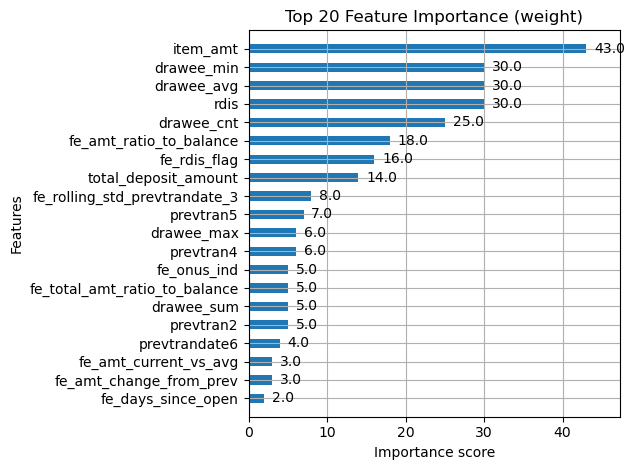

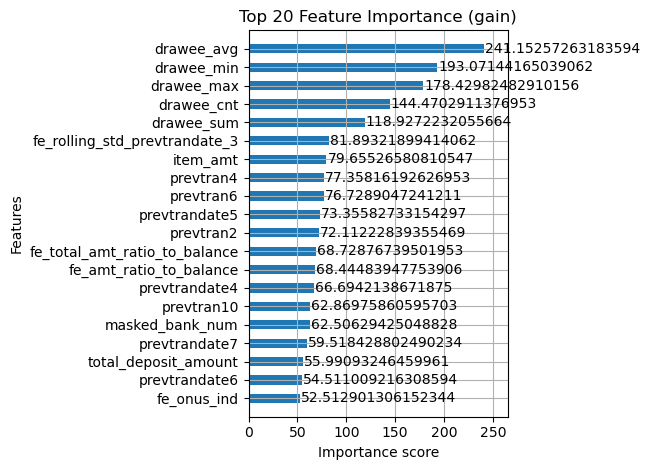

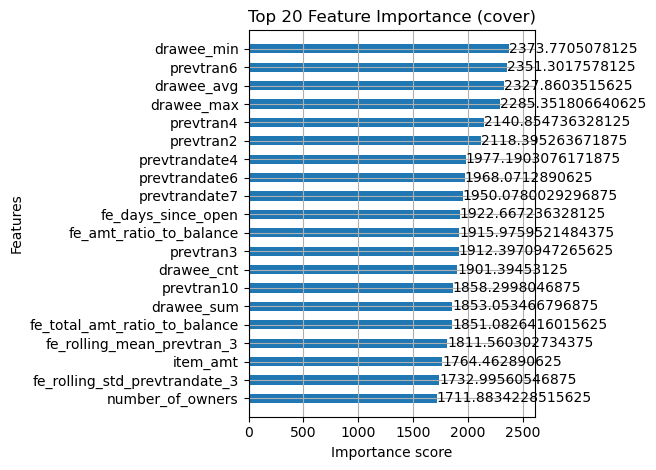

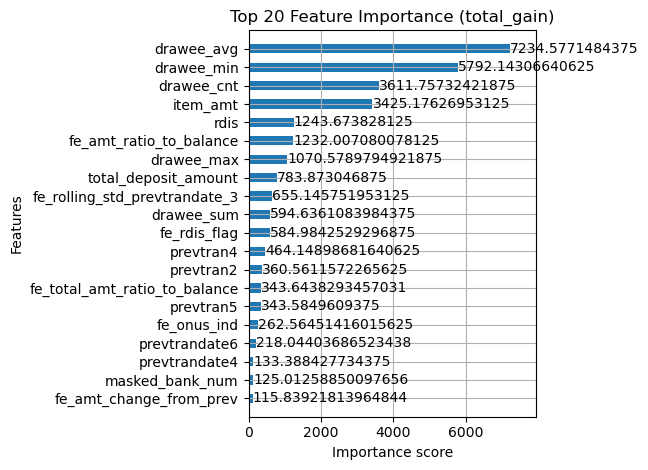

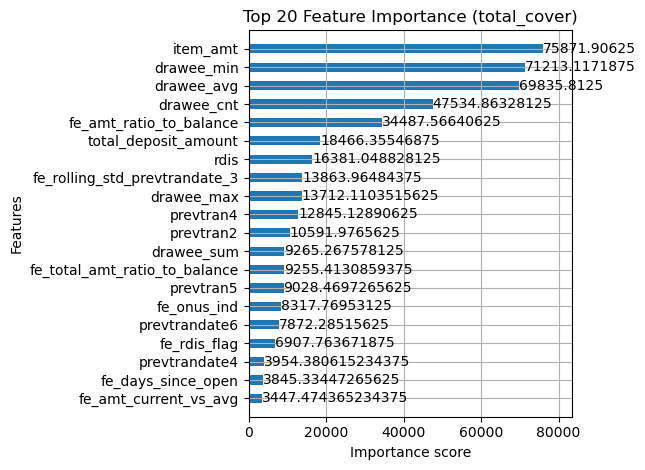

In [37]:
importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']

for imp_type in importance_types:
    xgb.plot_importance(final_model, importance_type=imp_type, max_num_features=20, height=0.5)
    plt.title(f"Top 20 Feature Importance ({imp_type})")
    plt.tight_layout()
    plt.show()


In [46]:
!pip install shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 84.6 MB/s eta 0:00:00:00:0100:01


/oscar/home/ywan1077/.conda/envs/citizens/lib/python3.12/site-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


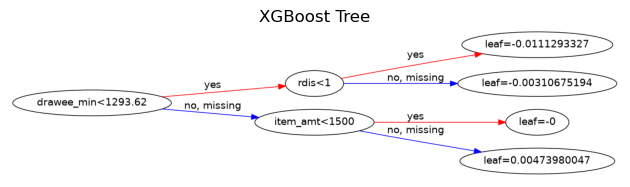

In [53]:
xgb.plot_tree(final_model, num_trees=3, rankdir='LR')  
plt.title("XGBoost Tree")
plt.tight_layout()
plt.show()